# NBA MVP Prediction

## Appending the csv files to create the Dataset 

In [1]:
import pandas as pd
import pathlib
import random as rd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from tqdm import tqdm

In [2]:
nba_dataset = pd.DataFrame()

for season in np.arange(1981,2021,1):
    df = pd.read_csv(f'./data/{season}_std.csv', low_memory=False)    
    nba_dataset = nba_dataset.append(df)

display(nba_dataset)
display(nba_dataset.info())

Player Pos  Age   Tm   G    MP   FG   FGA    FG%   3P  ...  \
0    Kareem Abdul-Jabbar   C   33  LAL  80  2976  836  1457  0.574    0  ...   
1          Tom Abernethy  SF   26  IND  39   298   25    59  0.424    0  ...   
2            Alvan Adams   C   26  PHO  75  2054  458   870  0.526    0  ...   
3         Darrell Allums  PF   22  DAL  22   276   23    67  0.343    0  ...   
4         Tiny Archibald  PG   32  BOS  80  2820  382   766  0.499    0  ...   
..                   ...  ..  ...  ...  ..   ...  ...   ...    ...  ...  ...   
524           Trae Young  PG   21  ATL  60  2120  546  1249  0.437  205  ...   
525          Cody Zeller   C   27  CHO  58  1341  251   479  0.524   18  ...   
526         Tyler Zeller   C   30  SAS   2     4    1     4  0.250    0  ...   
527           Ante Žižić   C   23  CLE  22   221   41    72  0.569    0  ...   
528          Ivica Zubac   C   22  LAC  72  1326  236   385  0.613    0  ...   

     WS/48  OBPM  DBPM   BPM  VORP  First  Share     Status  Season   W/L%  
0    0.230   4.7   1.4   6.1   6.1      8  0.414  Candidate    1981  0.659  
1    0.062  -2.2  -0.4  -2.6   0.0      0  0.000        OOR    1981  0.537  
2    0.180   2.5   2.6   5.1   3.7      0  0.000        OOR    1981  0.695  
3   -0.054  -5.5  -0.1  -5.6  -0.3      0  0.000        OOR    1981  0.183  
4    0.118   0.9  -1.0  -0.1   1.4      0  0.046  Candidate    1981  0.756  
..     ...   ...   ...   ...   ...    ...    ...        ...     ...    ...  
524  0.133   6.2  -2.3   3.9   3.1      0  0.000        OOR    2020  0.299  
525  0.129   0.2  -0.8  -0.6   0.5      0  0.000        OOR    2020  0.354  
526 -0.075  -0.3 -22.1 -22.4   0.0      0  0.000        OOR    2020  0.451  
527  0.106  -1.7  -1.5  -3.2  -0.1      0  0.000        OOR    2020  0.292  
528  0.241   1.9   0.8   2.8   1.6      0  0.000        OOR    2020  0.681  

[16852 rows x 53 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16852 entries, 0 to 528
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  16852 non-null  object 
 1   Pos     16852 non-null  object 
 2   Age     16852 non-null  int64  
 3   Tm      16852 non-null  object 
 4   G       16852 non-null  int64  
 5   MP      16852 non-null  int64  
 6   FG      16852 non-null  int64  
 7   FGA     16852 non-null  int64  
 8   FG%     16852 non-null  float64
 9   3P      16852 non-null  int64  
 10  3PA     16852 non-null  int64  
 11  3P%     16852 non-null  float64
 12  2P      16852 non-null  int64  
 13  2PA     16852 non-null  int64  
 14  2P%     16852 non-null  float64
 15  eFG%    16852 non-null  float64
 16  FT      16852 non-null  int64  
 17  FTA     16852 non-null  int64  
 18  FT%     16852 non-null  float64
 19  ORB     16852 non-null  int64  
 20  DRB     16852 non-null  int64  
 21  TRB     16852 non-null  int64  
 22  

None

Way too many features, we need to remove some of them.

## Feature Removing

In [3]:
cols = ['G','MP','FG','FG%','3P','2P','FT','TRB','DRB%','ORB%','OWS','DWS','WS/48','OBPM','DBPM','First']
print(f"Removing {len(cols)} features.")
nba_dataset = nba_dataset.drop(columns=cols)

Removing 16 features.


## Feature Analysis

<AxesSubplot:>

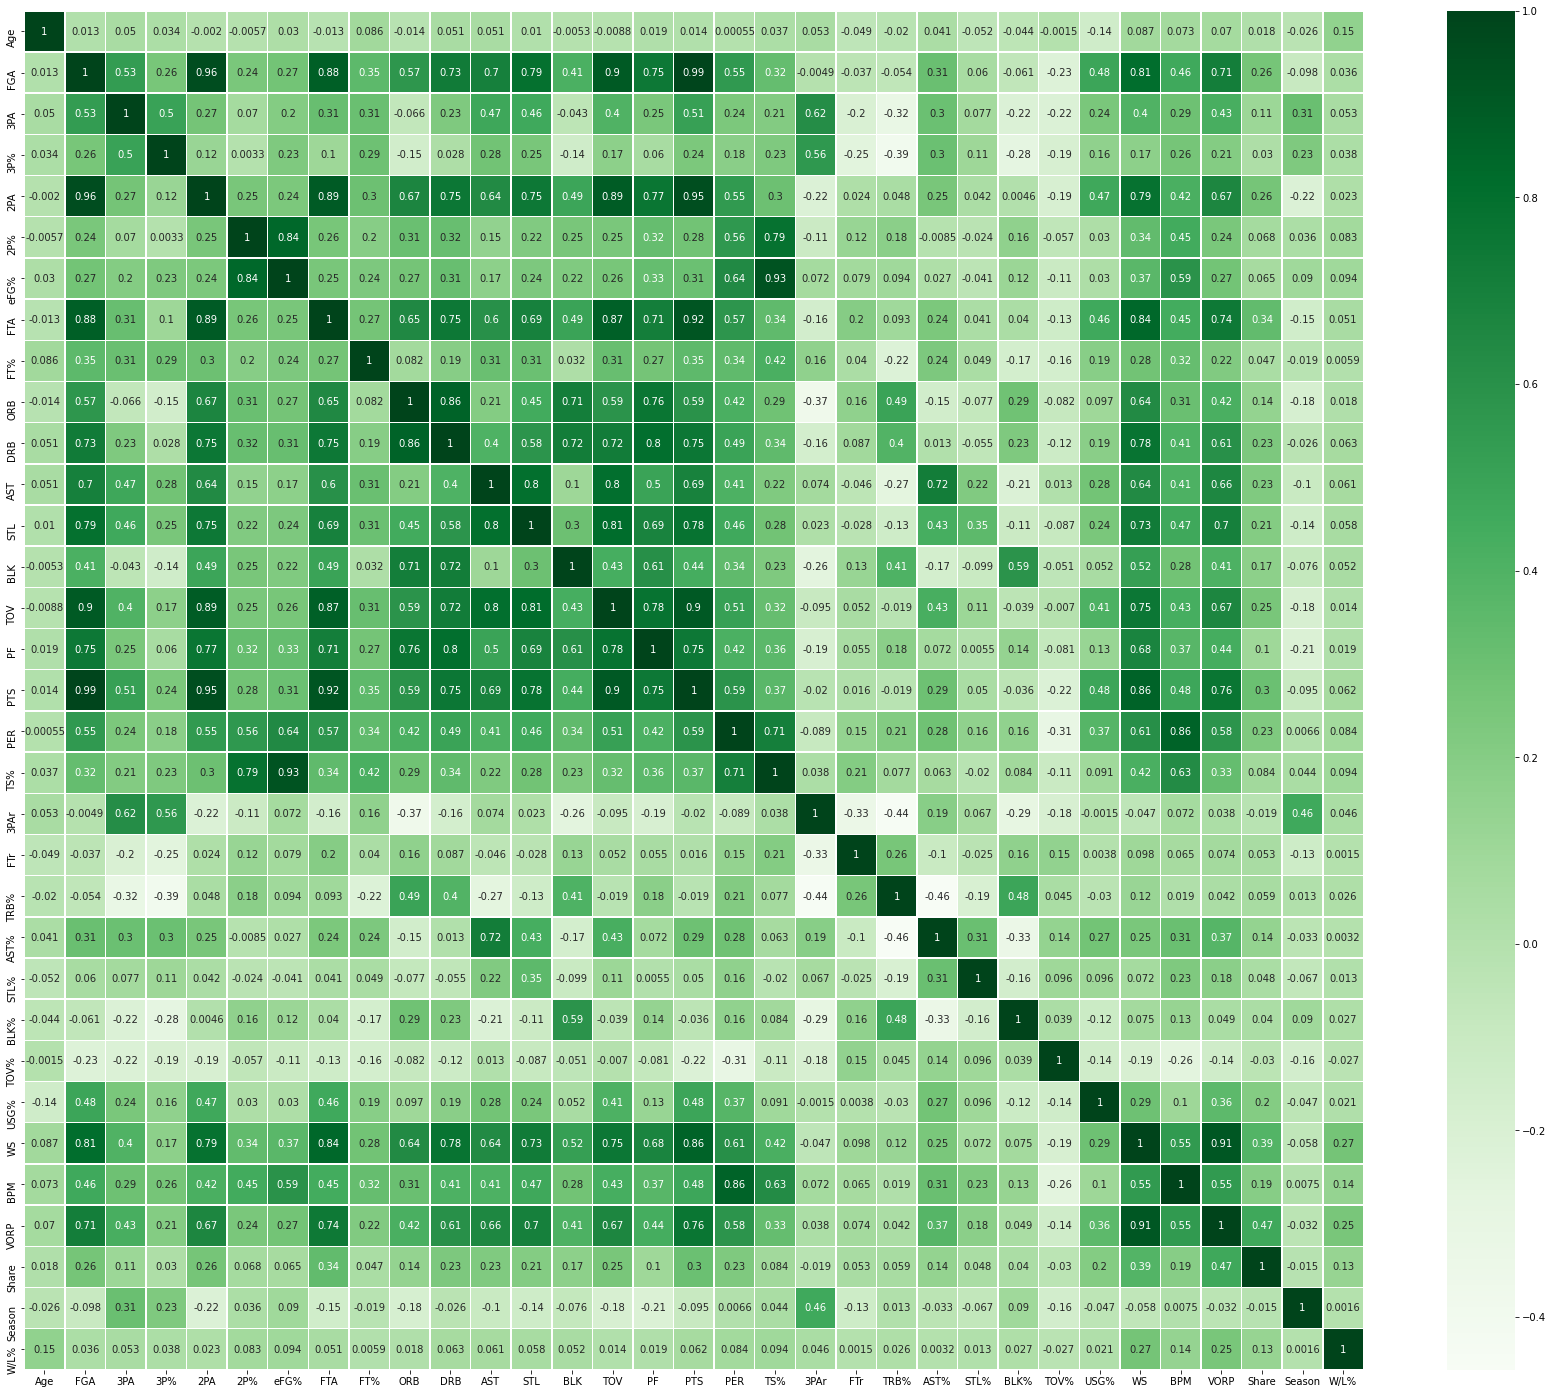

In [4]:
plt.figure(figsize=(30, 25))
sns.heatmap(nba_dataset.corr(), annot=True, cmap='Greens', linewidths=0.5)

I'm gonna keep some features just for further analysis. Once they are not usefull anymore I'll take them out.

## Outlier Analysis

### Functions Definition

In [5]:
def limit_calc(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [6]:
def boxplot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limit_calc(column))
    sns.boxplot(x=column, ax=ax2)
    
def histogram(column,color=None):
    plt.figure(figsize=(15, 5))
    sns.histplot(column,color=color)

def bar_chart(column):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    ax.set_xlim(limit_calc(column))

### 3-Point Field Goal Percentage

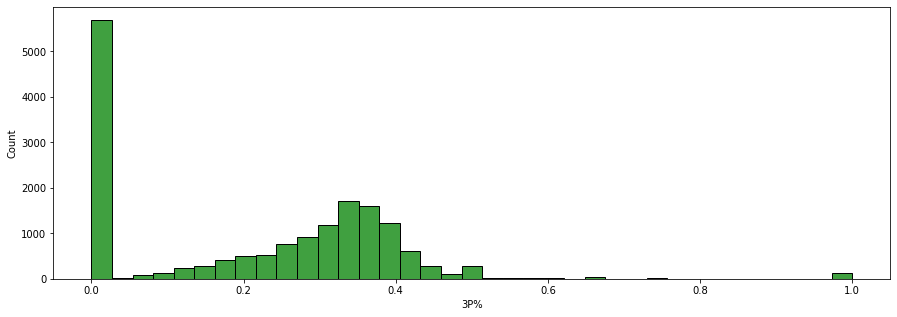

In [7]:
histogram(nba_dataset['3P%'],"Green")

Probably a fews guys had 1 3-pt attempt and managed to score. Those sharpshooters with 100% accuracy gonna be taken out.

Besides that, I gave 3 conditions to keep a player in the Dataset.
<ol>
    <li>Players within the margin: 0% ~ 60% </li>
    <li>Players with more than 60% accuracy can be counted if they tried at least 50 shoots in the season</li>
    <li>Kept the MVP and Candidates regardless their accuracy  </li>  
</ol>

In [8]:
min_val = 0.0
max_val = 0.6

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['3P%'] >= min_val) & (nba_dataset['3P%'] <= max_val)) 
                              | (nba_dataset['3P%'] > max_val) & (nba_dataset['3PA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

193 rows removed


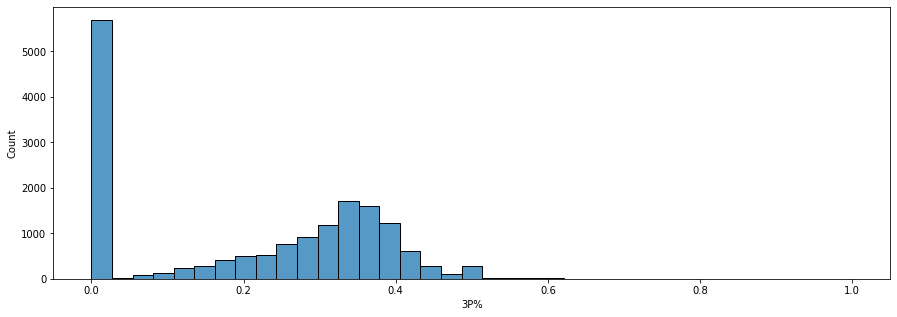

In [9]:
histogram(nba_dataset['3P%'])

### 2-Point Field Goal Percentage

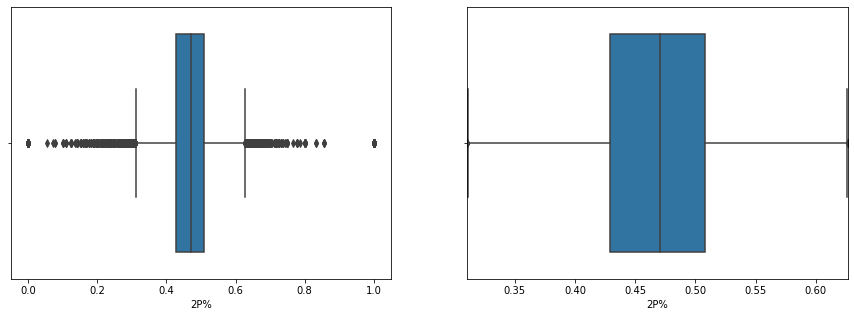

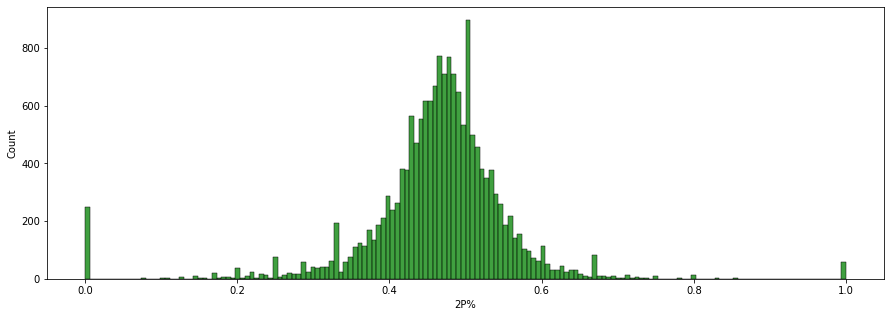

In [10]:
boxplot(nba_dataset['2P%'])
histogram(nba_dataset['2P%'],"Green")

Here again, some bench warmers are generating a few outliers.

The same 3 conditions will be repeated.<br> 
Here we gonna use a quantile (25% - 75%) calculation for the margins and we will consider 250 attempts to validate a outlier accuracy.

In [11]:
min_val, max_val = limit_calc(nba_dataset['2P%'])

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['2P%'] >= min_val) & (nba_dataset['2P%'] <= max_val)) 
                              | (nba_dataset['2P%'] > max_val) & (nba_dataset['2PA'] >= 250)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

1039 rows removed


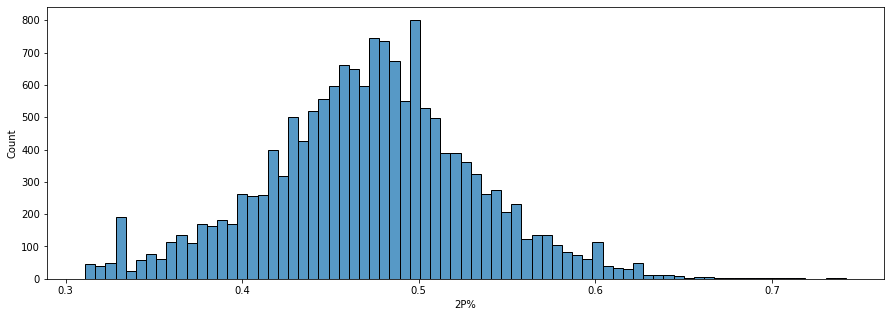

In [12]:
histogram(nba_dataset['2P%'])

We can see that there's still a few guys over 65% that may be outliers, let's check.

In [13]:
max_val = 0.65

outliers = nba_dataset.loc[(nba_dataset['2P%'] >= max_val) & (nba_dataset['2PA'] >= 250), :]
display(outliers)

Player Pos  Age   Tm  FGA  3PA    3P%  2PA    2P%   eFG%  ...  \
94       Artis Gilmore   C   31  CHI  816    0  0.000  816  0.670  0.670  ...   
329          Mark West   C   28  PHO  372    0  0.000  372  0.653  0.653  ...   
97       Erick Dampier   C   33  DAL  280    0  0.000  280  0.650  0.650  ...   
84      Tyson Chandler   C   28  DAL  407    0  0.000  407  0.654  0.654  ...   
245     DeAndre Jordan   C   22  LAC  341    1  0.000  340  0.688  0.686  ...   
85      Tyson Chandler   C   29  NYK  355    2  0.000  353  0.683  0.679  ...   
12      Chris Andersen   C   35  MIA  275   12  0.250  263  0.662  0.649  ...   
245     DeAndre Jordan   C   25  LAC  515    0  0.000  515  0.676  0.676  ...   
353      Mason Plumlee   C   23  BRK  302    3  0.000  299  0.666  0.659  ...   
474     Brandan Wright   C   26  DAL  331    0  0.000  331  0.677  0.677  ...   
88      Tyson Chandler   C   32  DAL  440    0  0.000  440  0.666  0.666  ...   
253     DeAndre Jordan   C   26  LAC  534    4  0.250  530  0.713  0.711  ...   
240     DeAndre Jordan   C   27  LAC  508    1  0.000  507  0.704  0.703  ...   
154        Rudy Gobert   C   24  UTA  625    1  0.000  624  0.662  0.661  ...   
174   Montrezl Harrell   C   23  HOU  345    7  0.143  338  0.663  0.654  ...   
239     DeAndre Jordan   C   28  LAC  577    2  0.000  575  0.717  0.714  ...   
292       JaVale McGee   C   29  GSW  319    3  0.000  316  0.658  0.652  ...   
84        Clint Capela   C   23  HOU  676    1  0.000  675  0.653  0.652  ...   
406       Jakob Poeltl   C   22  TOR  384    2  0.500  382  0.660  0.660  ...   
411      Dwight Powell   C   26  DAL  430   84  0.333  346  0.656  0.626  ...   
78       Thomas Bryant   C   21  WAS  502   99  0.333  403  0.685  0.648  ...   
186        Rudy Gobert   C   26  UTA  712    0  0.000  712  0.669  0.669  ...   
409      Dwight Powell   C   27  DAL  486  127  0.307  359  0.699  0.637  ...   
427  Mitchell Robinson   C   20  NYK  291    0  0.000  291  0.694  0.694  ...   
6        Jarrett Allen   C   21  BRK  465    6  0.000  459  0.658  0.649  ...   
101     Brandon Clarke  PF   23  MEM  479   64  0.359  415  0.658  0.642  ...   
175        Rudy Gobert   C   27  UTA  557    0  0.000  557  0.693  0.693  ...   
208       Jaxson Hayes   C   19  NOP  259    4  0.250  255  0.678  0.674  ...   
230      Dwight Howard   C   34  LAL  277    5  0.600  272  0.732  0.735  ...   
264     DeAndre Jordan   C   31  BRK  287    0  0.000  287  0.666  0.666  ...   
368       Nerlens Noel   C   25  OKC  269    3  0.333  266  0.688  0.686  ...   
427  Mitchell Robinson   C   21  NYK  341    0  0.000  341  0.742  0.742  ...   

     BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season   W/L%  
94    4.0  18.4  18.5  12.3  4.3   4.5  0.006  Candidate    1981  0.549  
329   5.1  18.3  11.1   5.5  1.0   1.5  0.000        OOR    1989  0.671  
97    3.8  17.8  10.4   6.1  0.6   1.2  0.000        OOR    2009  0.610  
84    3.0  14.1  14.2   9.4  1.5   1.8  0.000        OOR    2011  0.695  
245   5.4  18.8  11.7   5.2 -0.7   0.7  0.000        OOR    2011  0.390  
85    3.4  17.1  13.0   9.5  2.3   2.2  0.000        OOR    2012  0.545  
12    6.1  13.2  13.8   6.0  1.2   1.1  0.000        OOR    2014  0.659  
245   5.4  15.3  12.4  11.1  2.5   3.3  0.000        OOR    2014  0.695  
353   3.6  16.6  17.1   4.7  1.0   1.0  0.000        OOR    2014  0.537  
474   4.2   8.5  17.4   5.1  3.4   1.5  0.000        OOR    2014  0.598  
88    3.2  16.0  12.8  10.3  2.6   2.7  0.000        OOR    2015  0.610  
253   5.4  12.8  13.6  12.8  2.9   3.5  0.000        OOR    2015  0.683  
240   5.4  12.1  15.4  11.5  2.8   3.2  0.000        OOR    2016  0.646  
154   6.4  15.0  16.7  14.3  4.4   4.4  0.000        OOR    2017  0.622  
174   3.2   9.9  17.6   4.1  1.0   0.8  0.000        OOR    2017  0.671  
239   4.3  13.1  15.3  11.8  3.3   3.5  0.000        OOR    2017  0.622  
292   7.1   9.8  23.8   3.5  1.2   0.6  0.000        OOR    2017  0.817  
84    5.7 

As expected, all centers that love the rim.

### FT% : Free Throw Percentage

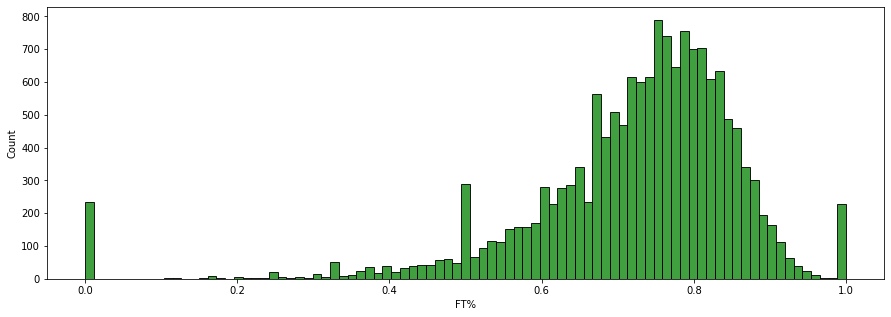

In [14]:
histogram(nba_dataset['FT%'],"Green")

It seems that too many guys had 0% or 100% accuracy. Again, weird numbers.

Gonna treat that, by taking the mean of Free Throw Attempts in count.

In [15]:
print(f"FTA mean: {nba_dataset['FTA'].mean():.0F}")

FTA mean: 146


So let's consider one third of the FTA mean (50 attempts) as the margin and see what happens.

In [16]:
df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

4671 rows removed


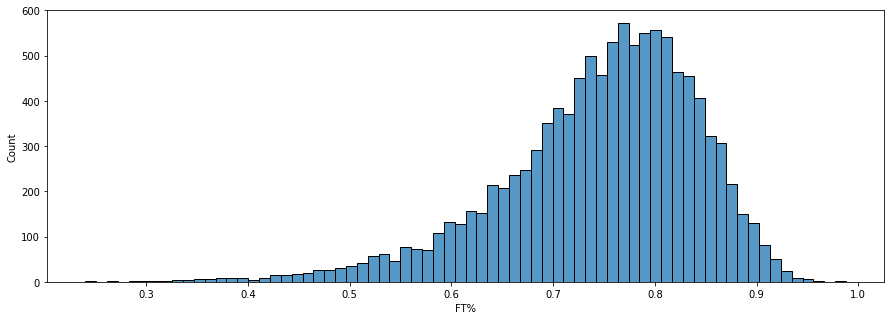

In [17]:
histogram(nba_dataset['FT%'])

#### Fun Fact Section

If you are wondering who are the guys below 35% free throw accuracy with 50 or more attempts, here are the nominees: 

In [18]:
dfloosers = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] <= 0.35), ['Player','Pos','FTA','FT%','Season']]

display(dfloosers.sort_values(by=['FT%','FTA'], ascending=[True,False]))

Player Pos  FTA    FT%  Season
313       Larry Smith  PF   50  0.240    1991
323    Olden Polynice   C   65  0.262    2001
128       Joey Dorsey  PF   83  0.289    2015
292       Ian Mahinmi   C  102  0.304    2015
284       Larry Smith  PF   58  0.310    1989
322    Olden Polynice   C   90  0.311    2000
86       Chris Dudley  PF  182  0.319    1990
51         Josh Boone  PF   58  0.328    2010
192     Steven Hunter   C   69  0.333    2004
110     DeSagana Diop   C   66  0.333    2009
416       Ben Wallace   C   57  0.333    2011
414       Ben Wallace   C  238  0.336    2001
65        Kwame Brown   C   98  0.337    2010
261     Eric Montross   C   62  0.339    1997
445        Jan Veselý  PF   56  0.339    2014
411  Lorenzo Williams   C   70  0.343    1996
55       Andrew Bogut   C   64  0.344    2014

A few famous names here. Congrats to the Wizards on drafting Kwame Brown as a first pick.

I think the ones with more than 95% should also have their names listed, so here it goes:

In [19]:
dfwow = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] >= 0.95), ['Player','Pos','FTA','FT%','Season']]

display(dfwow.sort_values(by=['FT%','FTA'], ascending=[False,False]))

Player Pos  FTA    FT%  Season
50      Terrell Brandon  PG   84  0.988    2002
73        José Calderón  PG  154  0.981    2009
201       Calvin Murphy  PG  215  0.958    1981
1    Mahmoud Abdul-Rauf  PG  229  0.956    1994
9             Ray Allen  SG  249  0.952    2009
271          Mark Price  PG   62  0.952    1991
15        Ryan Anderson  PF   62  0.952    2014
178       Jeff Hornacek  SG  180  0.950    2000

Now that the hard work is done, we can take out the attempts features.

In [20]:
nba_dataset = nba_dataset.drop(columns=['3PA','2PA','FTA','FGA','3PAr','FTr'])
display(nba_dataset)
nba_dataset.info()

Player Pos  Age   Tm    3P%    2P%   eFG%    FT%  ORB  DRB  \
0    Kareem Abdul-Jabbar   C   33  LAL  0.000  0.574  0.574  0.766  197  624   
2            Alvan Adams   C   26  PHO  0.000  0.526  0.526  0.768  157  389   
4         Tiny Archibald  PG   32  BOS  0.000  0.505  0.499  0.816   36  140   
6           James Bailey  PF   23  SEA  0.500  0.499  0.500  0.709  192  415   
7           Greg Ballard  SF   26  WSB  0.219  0.470  0.466  0.847  167  413   
..                   ...  ..  ...  ...    ...    ...    ...    ...  ...  ...   
521         Delon Wright  PG   27  DAL  0.370  0.504  0.519  0.770   70  210   
523       Thaddeus Young  PF   31  CHI  0.356  0.501  0.513  0.583   94  221   
524           Trae Young  PG   21  ATL  0.361  0.501  0.519  0.860   32  223   
525          Cody Zeller   C   27  CHO  0.240  0.577  0.543  0.682  160  251   
528          Ivica Zubac   C   22  LAC  0.000  0.616  0.613  0.747  197  346   

     ...  BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season   W/L%  
0    ...   4.0  12.8  26.3  14.3  6.1   6.1  0.414  Candidate    1981  0.659  
2    ...   1.9  18.7  23.0   7.7  5.1   3.7  0.000        OOR    1981  0.695  
4    ...   0.4  21.8  17.5   6.9 -0.1   1.4  0.046  Candidate    1981  0.756  
6    ...   3.1  17.3  20.3   4.9 -1.1   0.6  0.000        OOR    1981  0.415  
7    ...   0.8   8.4  21.4   6.9  2.2   2.8  0.000        OOR    1981  0.476  
..   ...   ...   ...   ...   ...  ...   ...    ...        ...     ...    ...  
521  ...   1.2  13.8  14.4   4.4  1.9   1.5  0.000        OOR    2020  0.573  
523  ...   1.4  13.9  19.7   1.9 -1.2   0.3  0.000        OOR    2020  0.338  
524  ...   0.3  16.2  34.9   5.9  3.9   3.1  0.000        OOR    2020  0.299  
525  ...   1.7  11.9  20.8   3.6 -0.6   0.5  0.000        OOR    2020  0.354  
528  ...   4.4  11.8  16.4   6.6  2.8   1.6  0.000        OOR    2020  0.681  

[10949 rows x 31 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10949 entries, 0 to 528
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  10949 non-null  object 
 1   Pos     10949 non-null  object 
 2   Age     10949 non-null  int64  
 3   Tm      10949 non-null  object 
 4   3P%     10949 non-null  float64
 5   2P%     10949 non-null  float64
 6   eFG%    10949 non-null  float64
 7   FT%     10949 non-null  float64
 8   ORB     10949 non-null  int64  
 9   DRB     10949 non-null  int64  
 10  AST     10949 non-null  int64  
 11  STL     10949 non-null  int64  
 12  BLK     10949 non-null  int64  
 13  TOV     10949 non-null  int64  
 14  PF      10949 non-null  int64  
 15  PTS     10949 non-null  int64  
 16  PER     10949 non-null  float64
 17  TS%     10949 non-null  float64
 18  TRB%    10949 non-null  float64
 19  AST%    10949 non-null  float64
 20  STL%    10949 non-null  float64
 21  BLK%    10949 non-null  float64
 22  

In [21]:
full_nba_dataset = nba_dataset

## Models

#### Decision Tree

#### Feature Selection

In [22]:
df_clear = pd.DataFrame()
feature_list = ['3P%', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'WS', 'BPM', 'VORP']
# ['VORP','WS','PER','BPM','PTS']
feature_values = []

for feature in feature_list:
    for season in np.arange(1981,2021,1):
        df = full_nba_dataset.loc[(full_nba_dataset['Season'] == season), ['Season','Player',feature,'Status']]
        df = df.sort_values(by=feature, ascending= False)

        if season == 1981:
            df_clear = df.iloc[:1]
        else:
            df_clear = df_clear.append(df.iloc[:1])

    df = df_clear.groupby('Status').size().reset_index(name='counts')
    df = df.sort_values(by='Status')
    
    df = df.set_index(['Status'])
    
#     display(df)
#     importance = (df.iat[1,1]/(df.iat[1,1]+df.iat[0,1]))*100
    try:
        importance = (df.at['MVP','counts']/40)
    except:
        importance = 0

    feature_values.append('{:.2f}'.format(importance)) 

dfts = pd.DataFrame()
dfts['Features'] = feature_list
dfts['Importance'] = feature_values
display(dfts.sort_values(by='Importance',ascending=False)) 


Features Importance
20       WS       0.55
22     VORP       0.50
12      PER       0.50
21      BPM       0.47
11      PTS       0.25
19     USG%       0.17
5       DRB       0.10
7       STL       0.07
6       AST       0.07
13      TS%       0.05
3       FT%       0.05
15     AST%       0.05
4       ORB       0.05
14     TRB%       0.03
1       2P%       0.00
10       PF       0.00
16     STL%       0.00
17     BLK%       0.00
18     TOV%       0.00
9       TOV       0.00
8       BLK       0.00
2      eFG%       0.00
0       3P%       0.00

3P%	0.018766
DRB	0.018592
TS%	0.017796
AST	0.016651
TOV%	0.016171
AST%	0.015202
STL	0.014527
eFG%	0.014288
TRB%	0.014069
ORB	0.013704
STL%	0.013133
2P%	0.012645
BLK	0.012509
BLK%	0.010437

In [23]:
def model_score(dataframe,model,features,iterations=1,path='./misses/trash'):
    
    pbar = tqdm(total = 40)
    
    nro_of_corrects = 0
    nro_of_top3_corrects = 0

    file = open(f"{path}/output.txt","w")
    
    file.write('Model : {}\n{} features : {}\n'.format(model,len(features),features))

    t1 = time.time()

    for season in np.arange(1981,2021,1):

        text = f' {season} |'

        y_train = dataframe.loc[(dataframe['Season'] != season),['Share']]
        y_train = np.ravel(y_train)
        y_test = dataframe.loc[(dataframe['Season'] == season),['Share']]
        y_test = np.ravel(y_test)

        X_train = dataframe.loc[(dataframe['Season'] != season),:].drop(['Share','Season'], axis=1)
        X_test = dataframe.loc[(dataframe['Season'] == season),:].drop(['Share','Season'], axis=1)

        players_rank = dict()
        df = full_nba_dataset.loc[(full_nba_dataset['Season'] == season),['Player','Share','Season']]
        df_truth = df.sort_values(by='Share', ascending=False)

        for i in range(iterations):

            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            df['Pred'] = pred.tolist()
            df_pred = df.drop(['Share'],axis=1).sort_values(by='Pred', ascending=False)

            for j in range(5):
                if df_pred.iat[j,0] in players_rank.keys():
                    players_rank[df_pred.iat[j,0]] += (10-(j*2))
                else:
                    players_rank[df_pred.iat[j,0]] = (10-(j*2))

        players_columns = list(players_rank.keys())
        votes_columns = []

        for k in players_columns:
            votes_columns.append(players_rank[k])

        data = dict()
        data['Player'] = players_columns
        data['Season'] = season
        data['Pred'] = votes_columns

        df_pred_final = pd.DataFrame(data)
        df_pred_final = df_pred_final.sort_values(by='Pred', ascending=False)
        df_pred_final.to_csv(f"./predictions/{season}_pred.csv")

        pred_top3 = list(df_pred_final['Player'].iloc[:3])
        top3 = list(df_truth['Player'].iloc[:3]) 
        top3_success = list()

        for z in pred_top3:
            if z in top3:
                top3_success.append(z)

        df_comp = pd.DataFrame()

        if pred_top3[0] == top3[0]:
            sorf = 'Success'
            nro_of_corrects += 1
        else:
            sorf = 'Fail'
            df_comp = full_nba_dataset.loc[(full_nba_dataset['Season'] == season) & (full_nba_dataset['Player'] == top3[0]) ,:]
            df_comp = df_comp.append(full_nba_dataset.loc[(full_nba_dataset['Season'] == season) & (full_nba_dataset['Player'] == pred_top3[0]) ,:])
            df_comp['Label'] = ['Correct','Predicted']
            df_comp.to_csv('{}/{}_miss.csv'.format(path,season),index=False)

        text += '{:^10s}| '.format(sorf)


        text += f'{len(top3_success)} from de top3 correct | {top3_success} |\n'
        nro_of_top3_corrects += len(top3_success)

        file.write(str(text))
        
        pbar.update()

    text = "GLOBAL_SUCCESS_RATE : {:.2%}\nGLOBAL_SUCCESS_RATE_TOP3 : {:.2%}\n".format((nro_of_corrects/40),(nro_of_top3_corrects/120))
#     print(text)
    file.write(str(text))
    t2 = time.time()

    text = 'Time elapsed: {:.2f} seconds'.format(t2-t1)
    file.write(str(text))
    file.close()

100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


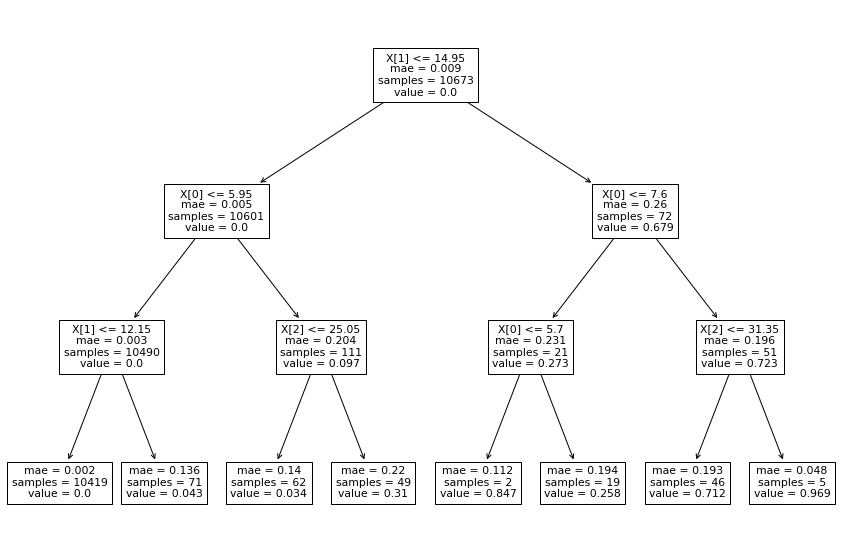

In [24]:
nba_dataset = full_nba_dataset[['VORP','WS','PER','BPM','Season','Share']]
choosen_model = tree.DecisionTreeRegressor(criterion='mae',max_depth=3)
model_score(dataframe=nba_dataset,model=choosen_model,features=['VORP','WS','PER','BPM'],iterations=1,path='./misses/decision_three')

plt.figure(figsize=(15, 10))
tree.plot_tree(choosen_model)  
plt.show()

Features  Importance
22     VORP    0.313497
20       WS    0.190478
12      PER    0.098762
19     USG%    0.052920
21      BPM    0.051867
11      PTS    0.036421
3       FT%    0.026662
9       TOV    0.020621
15     AST%    0.019531
0       3P%    0.018746
10       PF    0.018424
2      eFG%    0.018295
6       AST    0.017825
13      TS%    0.016237
5       DRB    0.016091
14     TRB%    0.013496
1       2P%    0.012106
4       ORB    0.011281
18     TOV%    0.011224
7       STL    0.010397
8       BLK    0.010229
17     BLK%    0.008568
16     STL%    0.006322

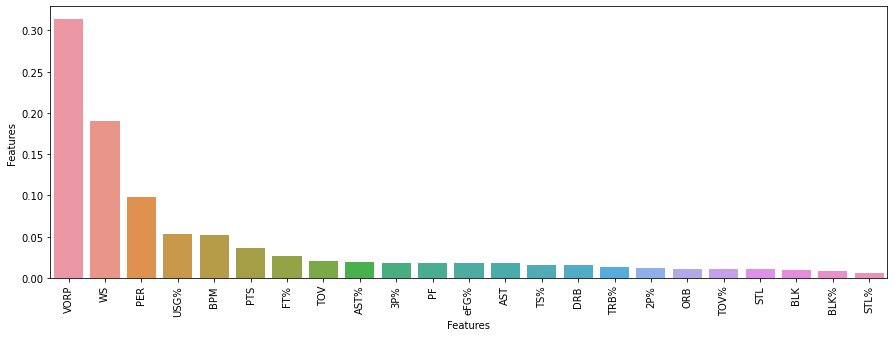

<Figure size 2160x1800 with 0 Axes>

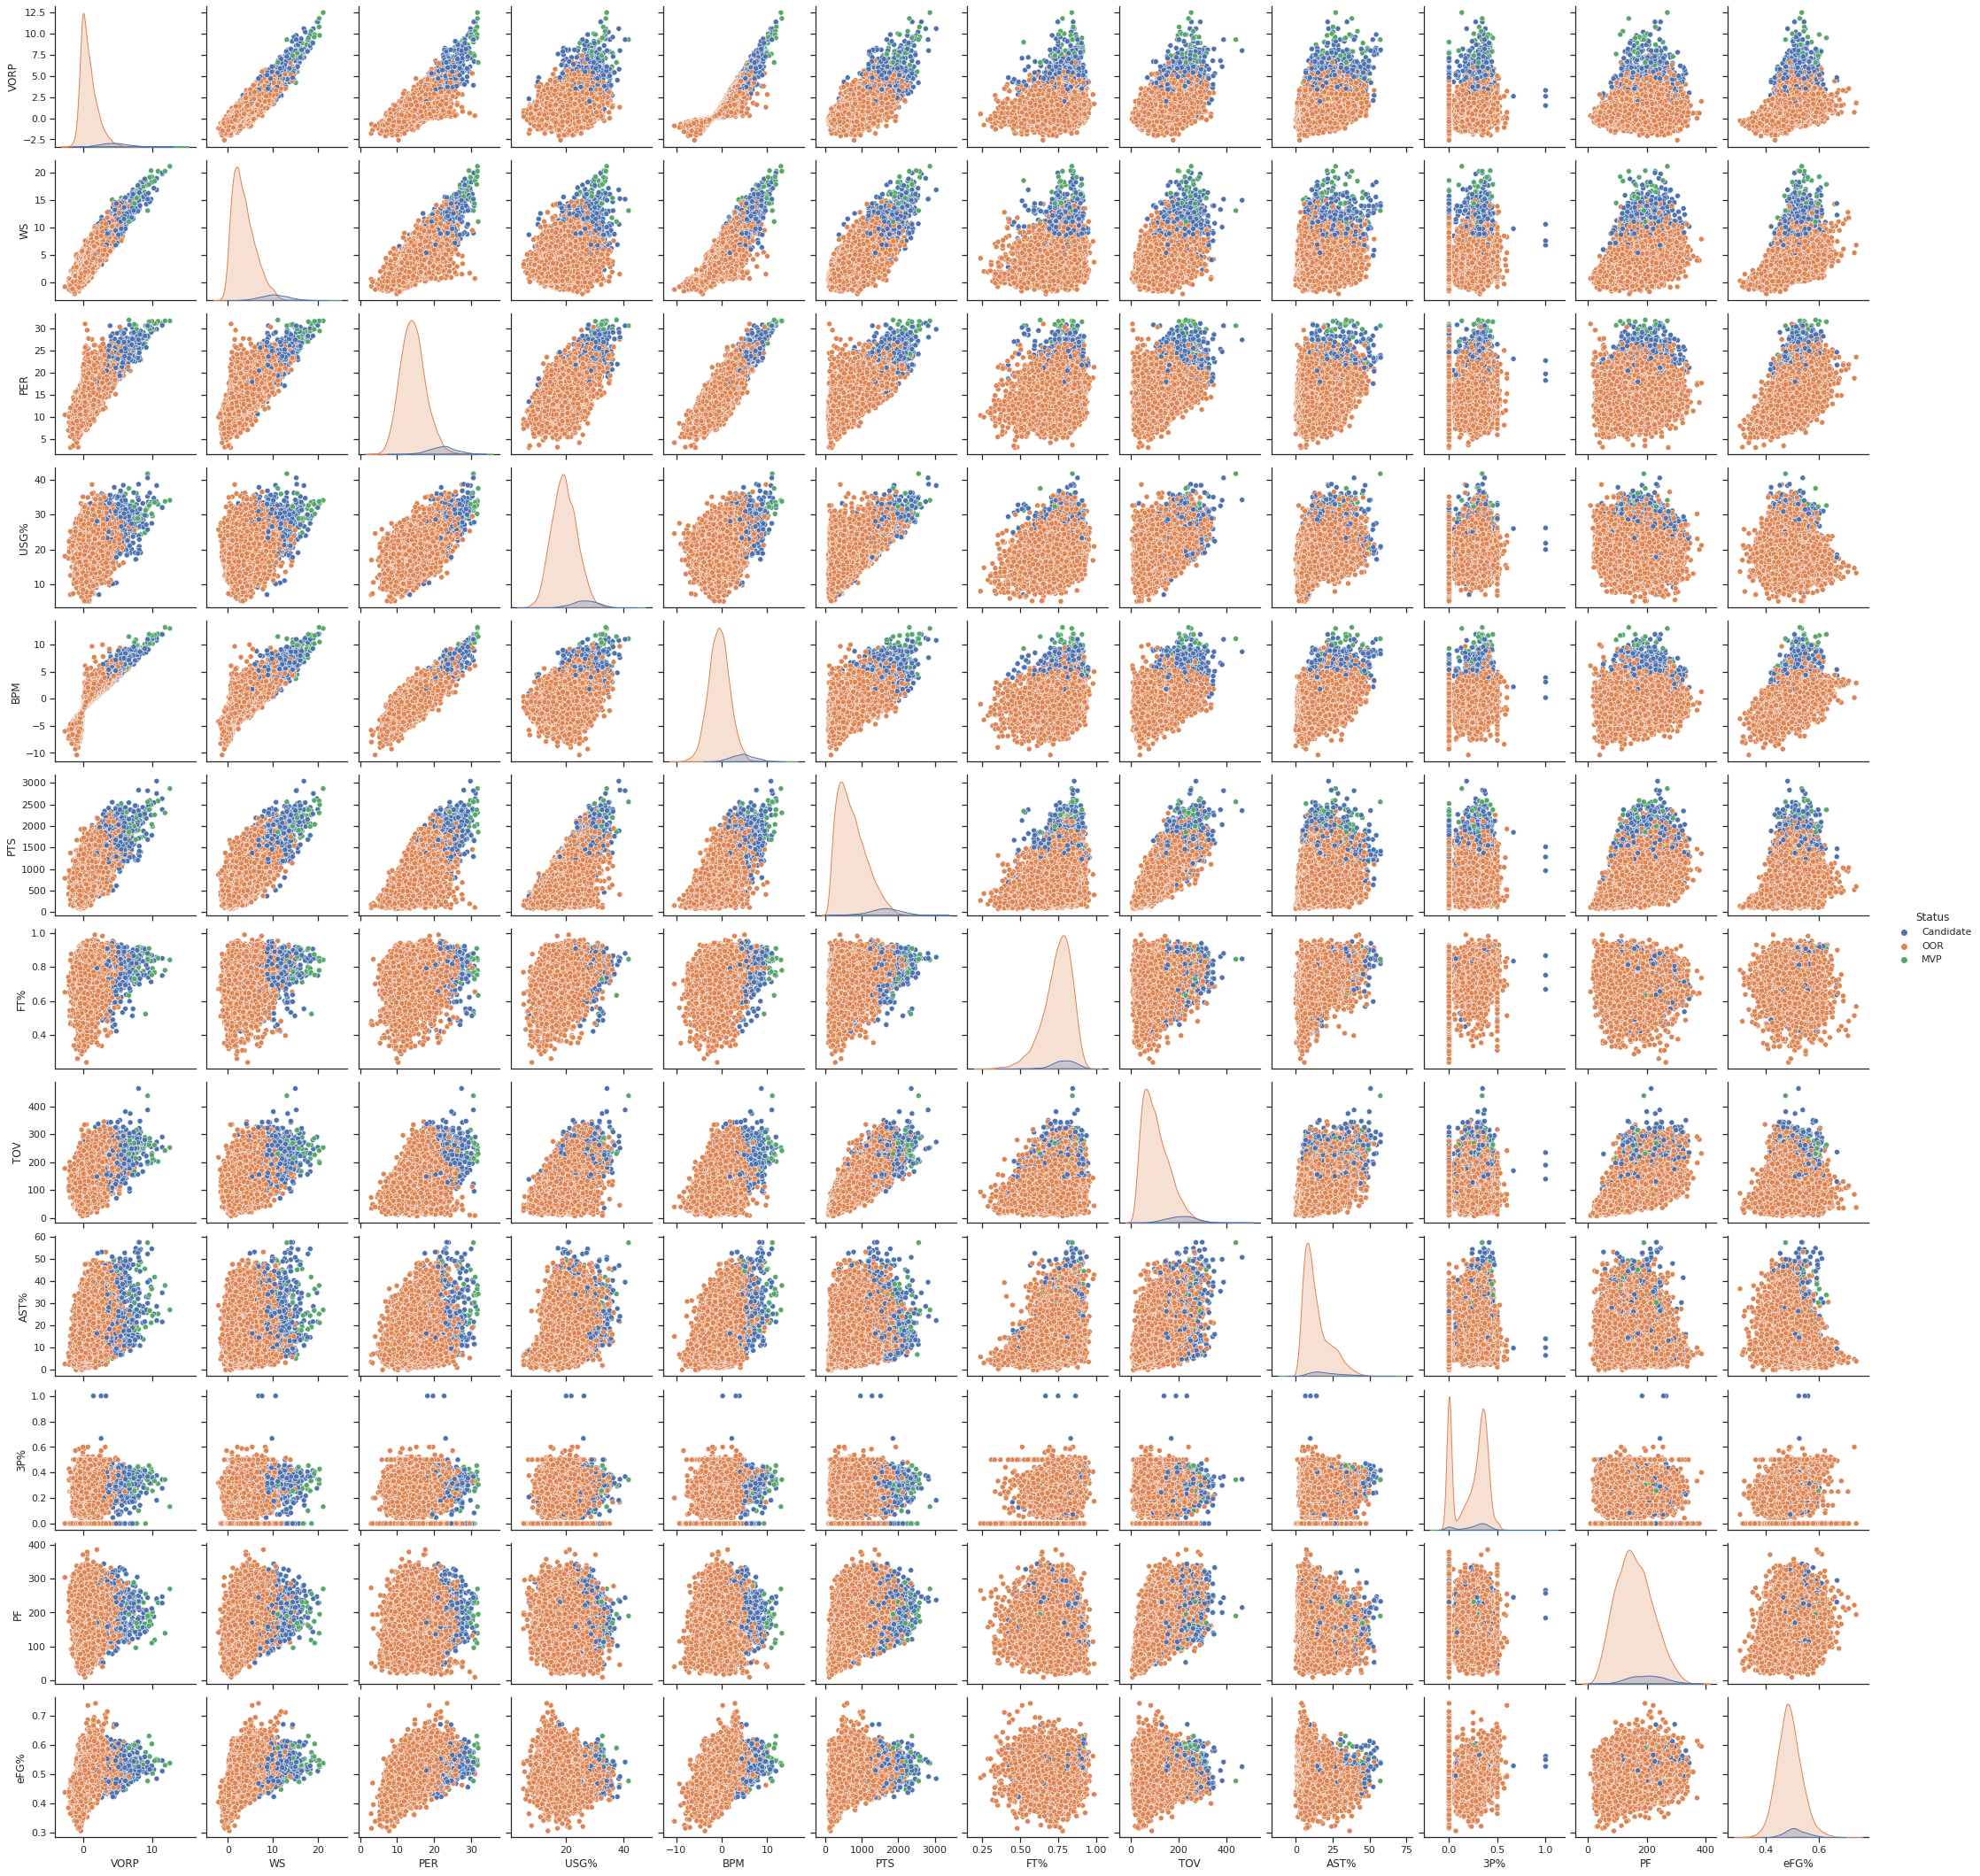

In [25]:
# model = ExtraTreesRegressor()
model = RandomForestRegressor()

# Literal Data
cols = ['Player', 'Pos', 'Age','Status','Tm','W/L%'] 
nba_dataset = full_nba_dataset.drop(cols,axis=1)
X = nba_dataset.drop(['Share','Season'], axis=1)
y = nba_dataset['Share']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=10)

# clf=RandomForestClassifier(n_estimators =10, random_state = 42, class_weight="balanced")

model.fit(X_train, y_train)

data_dict = { 'Features' : X_train.columns, 'Importance' : model.feature_importances_ }
# data_dict['Features'] = X_train.columns
# data_dict['Importance'] = model.feature_importances_

features = pd.DataFrame(data_dict).sort_values(by='Importance',ascending=False)
display(features)

nro_of_features = 12
feature_list = list(features['Features'][:nro_of_features])

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=features['Features'], y=features['Importance'])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Features')

plt.figure(figsize=(30, 25)) 
sns.set_theme(style="ticks")
feature_list.append('Status')
sns.pairplot(full_nba_dataset[feature_list], hue="Status")

In [26]:
# [['VORP', 'WS', 'PER', 'BPM', 'USG%', 'PTS', 'Share', 'Season']]
# nba_dataset = full_nba_dataset.drop(['Player', 'Pos', 'Age','Status'],axis=1)
feature_list.extend(['Share', 'Season'])
print(feature_list)

nba_dataset = full_nba_dataset[feature_list].drop('Status',axis=1)

# nba_dataset = full_nba_dataset[['VORP', 'WS', 'PER', 'BPM', 'Share', 'Season']]
choosen_model = RandomForestRegressor(n_estimators=10,criterion='mse',max_depth=9)
model_score(dataframe=nba_dataset,model=choosen_model,features=feature_list,iterations=10,path='./misses/random_forest')

# criterion='mae',max_depth=3

  0%|          | 0/40 [00:00<?, ?it/s]

['VORP', 'WS', 'PER', 'USG%', 'BPM', 'PTS', 'FT%', 'TOV', 'AST%', '3P%', 'PF', 'eFG%', 'Status', 'Share', 'Season']


100%|██████████| 40/40 [02:17<00:00,  3.36s/it]

At this point I figured out that maybe the team performance in the regular season also impacts the mvp choice.

To cover the team performance I had to do a few changes on the scrapping and standardize codes.

Player   W/L%  Season
186           Moses Malone  0.561    1982
457      Russell Westbrook  0.573    2017
145         Michael Jordan  0.610    1988
294             Steve Nash  0.659    2006
185          Allen Iverson  0.683    2001
65             Kobe Bryant  0.695    2008
153          Magic Johnson  0.695    1989
232           LeBron James  0.697    2012
120             Tim Duncan  0.707    2002
274        Hakeem Olajuwon  0.707    1994
142          Kevin Garnett  0.707    2004
133           Kevin Durant  0.720    2014
108             Tim Duncan  0.732    2003
17   Giannis Antetokounmpo  0.732    2019
230            Karl Malone  0.740    1999
221           LeBron James  0.744    2010
174         Michael Jordan  0.744    1991
23         Charles Barkley  0.756    1993
305         David Robinson  0.756    1995
355           Derrick Rose  0.756    2011
301             Steve Nash  0.756    2005
202         Michael Jordan  0.756    1998
15              Larry Bird  0.756    1984
82           Julius Erving  0.756    1981
12   Giannis Antetokounmpo  0.767    2020
160          Magic Johnson  0.768    1990
15              Larry Bird  0.768    1985
227            Karl Malone  0.780    1997
132          Magic Johnson  0.793    1987
177           Moses Malone  0.793    1983
193           James Harden  0.793    2018
207           LeBron James  0.805    2009
211           LeBron James  0.805    2013
301          Dirk Nowitzki  0.817    2007
179         Michael Jordan  0.817    1992
16              Larry Bird  0.817    1986
111          Stephen Curry  0.817    2015
293       Shaquille O'Neal  0.817    2000
189         Michael Jordan  0.878    1996
104          Stephen Curry  0.890    2016

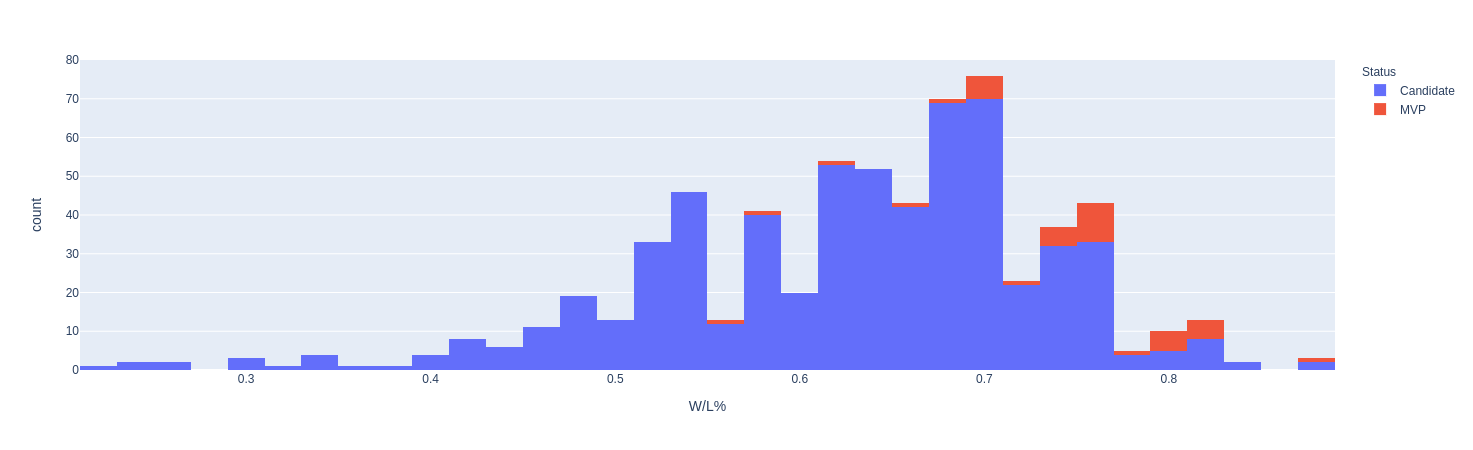

<AxesSubplot:xlabel='Season', ylabel='W/L%'>

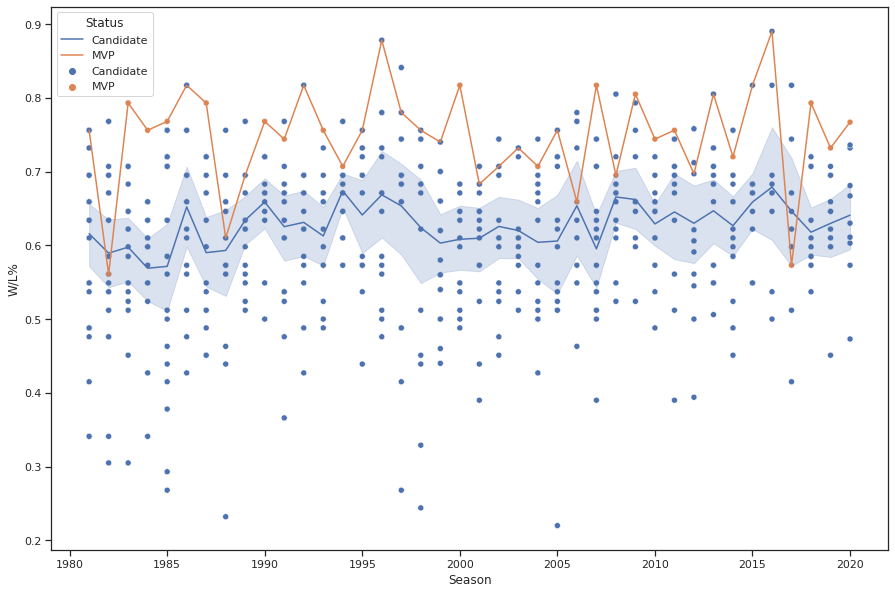

In [27]:
df = full_nba_dataset.loc[full_nba_dataset['Status'] == 'MVP', ['Player','W/L%','Season']]

display(df.sort_values(by='W/L%'))

df = full_nba_dataset.loc[full_nba_dataset['Status'] != 'OOR', ['Player','W/L%','Season','Status','Share']]

fig = px.histogram(df, x='W/L%', color='Status')
fig.show()

plt.figure(figsize=(15, 10)) 
sns.set_theme(style="ticks")
sns.scatterplot(x=df['Season'], y=df['W/L%'], hue=df['Status'])
sns.lineplot(x=df['Season'], y=df['W/L%'], hue=df['Status'])

We can see that bad teams could make a Candidate, but it's not likely to make the MVP.


 90%|█████████ | 36/40 [00:00<00:00, 46.82it/s]

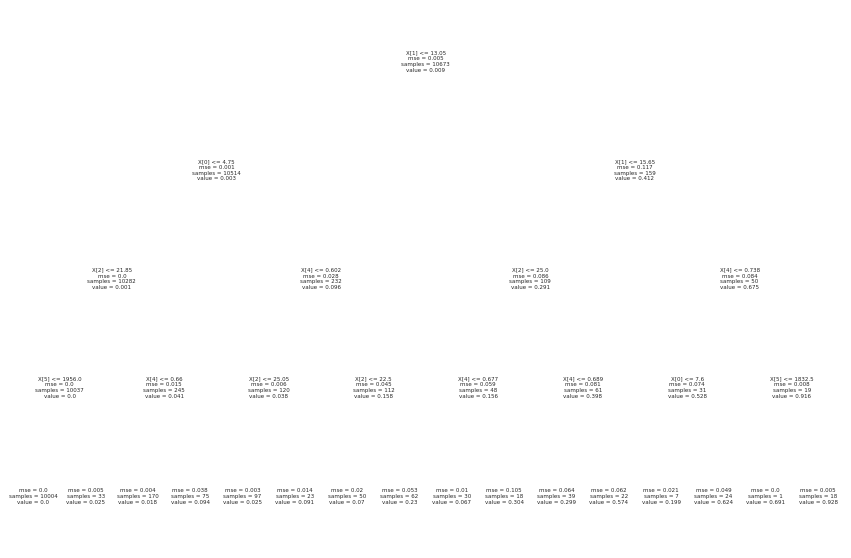

100%|██████████| 40/40 [00:01<00:00, 27.86it/s]


In [28]:
nba_dataset = full_nba_dataset[['VORP','WS','PER','BPM','W/L%','PTS','Season','Share']]
choosen_model = tree.DecisionTreeRegressor(criterion='mse',max_depth=4)
model_score(dataframe=nba_dataset,model=choosen_model,features=['VORP','WS','PER','BPM','W/L%'],iterations=1,path='./misses/decision_three')

plt.figure(figsize=(15, 10))
tree.plot_tree(choosen_model)  
plt.show()

In [32]:
feature_list = ['VORP', 'WS', 'PER', 'BPM', 'USG%', 'PTS', 'W/L%']
nba_dataset = full_nba_dataset.drop(['Player', 'Pos', 'Age','Status','Tm'],axis=1)
feature_list.extend(['Share', 'Season'])
print(feature_list)

choosen_model = RandomForestRegressor(n_estimators=10,criterion='mse',max_depth=5)
model_score(dataframe=nba_dataset,model=choosen_model,features=feature_list,iterations=5,path='./misses/random_forest')

# criterion='mae',max_depth=3





  0%|          | 0/40 [00:00<?, ?it/s]

['VORP', 'WS', 'PER', 'BPM', 'USG%', 'PTS', 'W/L%', 'Share', 'Season']






  2%|▎         | 1/40 [00:01<01:11,  1.84s/it]



  5%|▌         | 2/40 [00:03<01:10,  1.86s/it]



  8%|▊         | 3/40 [00:05<01:08,  1.85s/it]



 10%|█         | 4/40 [00:07<01:06,  1.85s/it]



 12%|█▎        | 5/40 [00:09<01:04,  1.85s/it]



 15%|█▌        | 6/40 [00:11<01:02,  1.85s/it]



 18%|█▊        | 7/40 [00:13<01:01,  1.86s/it]



 20%|██        | 8/40 [00:14<00:59,  1.85s/it]



 22%|██▎       | 9/40 [00:16<00:57,  1.86s/it]



 25%|██▌       | 10/40 [00:18<00:55,  1.85s/it]



 28%|██▊       | 11/40 [00:20<00:53,  1.86s/it]



 30%|███       | 12/40 [00:22<00:52,  1.88s/it]



 32%|███▎      | 13/40 [00:24<00:50,  1.87s/it]



 35%|███▌      | 14/40 [00:26<00:48,  1.86s/it]



 38%|███▊      | 15/40 [00:27<00:46,  1.85s/it]



 40%|████      | 16/40 [00:29<00:44,  1.84s/it]



 42%|████▎     | 17/40 [00:31<00:42,  1.84s/it]



 45%|████▌     | 18/40 [00:33<00:40,  1.83s/it]



 48%|████▊     | 19/40 [00:35<00:38,  1.83s/it]



 50%|█████     | 20/40 [00:36<00:36,